# Imports

In [1]:
import pandas as pd
import numpy
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
import numpy as np
import torch
from tqdm import tqdm

In [2]:
import torch
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from torch import nn
import torchvision, torch
from torchvision import transforms as T
from torch import optim
import copy

In [4]:
import scipy.io as sio

In [5]:
tqdm.pandas()

# load data

In [26]:
path = 'C:/Users/ht_13/OneDrive/Documents/6140-ML/Project/'
# load test result file
test_author = sio.loadmat(path+'dataset/dataset/test_author.mat')["test_author"]
# load train dataFrame
train_df = pd.read_csv(path+'dataset/dataset/Gungor_2018_VictorianAuthorAttribution_data-train.csv',encoding = "ISO-8859-1")
# load train dataFrame
test_df = pd.read_csv(path+'dataset/dataset/Gungor_2018_VictorianAuthorAttribution_data.csv',encoding = "ISO-8859-1")
# load list of authors
f = open('author_list.txt', 'r')
author_list = f.read().split('\n')
f.close()

In [27]:
test_df['author'] = test_author.reshape((test_df.shape[0]))
missing_authors = [5, 7, 31, 47, 49]
test_df = test_df.loc[~(test_df['author'].isin(missing_authors))]

In [28]:
test_df['author'] = test_df['author']-1

In [10]:
test_df.head()

,text,author
0,nt it seems te me how much money is he worth a...,0
1,to talk about why you heard of such a case as ...,0
2,my foot on the ground and said i believe you d...,0
3,hour or wait for miss oh wait for by all means...,0
4,will not listen to such words now go and remem...,0


#### Get Authors Names

In [10]:
author_list_path='./dataset/author_list.txt'

In [11]:
train_df['author'] = train_df['author']-1

In [12]:
train_df.head()

,text,author
0,ou have time to listen i will give you the ent...,0
1,wish for solitude he was twenty years of age a...,0
2,and the skirt blew in perfect freedom about th...,0
3,of san and the rows of shops opposite impresse...,0
4,an hour s walk was as tiresome as three in a s...,0


### Split the training data

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_set, valid_set = train_test_split(train_df ,test_size=0.2,shuffle=True)

In [13]:
train_set.shape

(42942, 2)

In [14]:
valid_set.shape

(10736, 2)

In [29]:
from nltk.tokenize import word_tokenize

In [ ]:
train_set['text'] = train_set['text'].progress_apply(lambda x:" ".join(word_tokenize(x)))
train_set.head()

In [30]:
test_df['text'] = test_df['text'].progress_apply(lambda x:" ".join(word_tokenize(x)))

100%|███████████████████████████████████████████████████████████████████████████| 25636/25636 [00:45<00:00, 565.03it/s]


In [20]:
train_set['text_length'] = train_set['text'].progress_apply(lambda x: len(x.split(" ")))

In [31]:
test_df['text_length'] = test_df['text'].progress_apply(lambda x: len(x.split(" ")))

100%|█████████████████████████████████████████████████████████████████████████| 25636/25636 [00:00<00:00, 32094.06it/s]


In [35]:
test_df.head()

,text,author,text_length
0,nt it seems te me how much money is he worth a...,0,1001
1,to talk about why you heard of such a case as ...,0,1000
2,my foot on the ground and said i believe you d...,0,1000
3,hour or wait for miss oh wait for by all means...,0,1001
4,will not listen to such words now go and remem...,0,1000


## Prepare Embeddings

In [32]:
MAX_SENTENCE_LENGTH = test_df['text_length'].max()
EMBEDDING_DIM = 100

In [33]:
print(MAX_SENTENCE_LENGTH)

1011


In [34]:
embedding_dictionary = {}
with open('C:/Users/ht_13/Downloads/Authorship_Attribution-master/Authorship_Attribution-master/glove.6B.100d.txt','r',encoding="utf8") as glove_file:
    for line in glove_file:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dictionary[word]=vectors
glove_file.close()

In [35]:
#Generate Embedding Matrix
def generate_word_embeddings(text):
    embedding_matrix = torch.zeros((1008, 100))
    for idx, word in enumerate(text.split(" ")):
        if(idx>1007):
            break
        if(word in embedding_dictionary):
            embedding_vector = torch.from_numpy(embedding_dictionary.get(word))
            if(embedding_vector is not None):
                embedding_matrix[idx] = embedding_vector
    return embedding_matrix

In [30]:
train_set['embeddings'] = train_set['text'].progress_apply(lambda x:generate_word_embeddings(x))

In [31]:
train_set.to_pickle('auth_id_train_df.pkl')

In [33]:
valid_set['embeddings'] = valid_set['text'].progress_apply(lambda x:generate_word_embeddings(x))

100%|███████████████████████████████████████████████████████████████████████████| 10736/10736 [00:48<00:00, 220.81it/s]


In [34]:
valid_set.to_pickle('auth_id_valid_df.pkl')

In [36]:
test_df['embeddings'] = test_df['text'].progress_apply(lambda x:generate_word_embeddings(x))

100%|███████████████████████████████████████████████████████████████████████████| 25636/25636 [01:48<00:00, 235.23it/s]


In [ ]:
test_df.to_pickle('auth_id_test_df.pkl')

In [34]:
test_df.head()

,text,author,text_length,embeddings
0,nt it seems te me how much money is he worth a...,0,1001,"[[tensor(0.3181), tensor(1.0088), tensor(-0.26..."
1,to talk about why you heard of such a case as ...,0,1000,"[[tensor(-0.1897), tensor(0.0500), tensor(0.19..."
2,my foot on the ground and said i believe you d...,0,1000,"[[tensor(0.0803), tensor(-0.1086), tensor(0.72..."
3,hour or wait for miss oh wait for by all means...,0,1001,"[[tensor(-0.3571), tensor(-0.2348), tensor(0.0..."
4,will not listen to such words now go and remem...,0,1000,"[[tensor(-0.2670), tensor(0.4491), tensor(0.55..."


In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

## Model training and testing

In [6]:
class GRU(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,out_dim):
        super(GRU,self).__init__()
        
        #Hidden Dimensions
        self.hidden_dim = hidden_dim
        
        #Number of Hidden Layers
        self.num_layers = num_layers

        #Building LSTM
        self.gru = nn.GRU(input_dim,hidden_dim,num_layers, batch_first = True)
        self.sequential = nn.Sequential(nn.Linear(hidden_dim, 2*hidden_dim),nn.ReLU(),nn.Linear(2*hidden_dim, hidden_dim),nn.ReLU())
        self.fc = nn.Linear(hidden_dim, out_dim)
    
    def forward(self,x):
        out, hn = self.gru(x)
        out = self.sequential(out)
        out = self.fc(out[:, -1, :])
        return out

# Build Custom Dataset

In [7]:
class AuthorTextDataset(torch.utils.data.Dataset):
    def __init__(self,dataframe):
        embeddings = dataframe['embeddings'].values
        authors = dataframe['author'].values
        
        self.x = embeddings
        self.y = torch.tensor(authors)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

#### Load the Saved Embedding Space

In [8]:
%time train_set = pd.read_pickle("pickle/auth_id_train_df.pkl")
%time valid_set = pd.read_pickle("pickle/auth_id_valid_df.pkl")

Wall time: 1min 19s
Wall time: 11.9 s


# Generate Dataloaders

In [9]:
train_dataset = AuthorTextDataset(train_set)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=128,shuffle=False)

validation_dataset = AuthorTextDataset(valid_set)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=128,shuffle=False)

In [37]:
test_dataset = AuthorTextDataset(test_df)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=128,shuffle=False)

In [10]:
def get_device():
#     return torch.device("cpu")
    if(torch.cuda.is_available()):
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [11]:
print(get_device())

cuda


# Training and Validation Pipeline

In [12]:
def train(model,data_loader, optimizer, criterion, device):
    model.to(device)
    model.train()
    correct = 0
    total = 0
    num_batches = 0
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (feature_data,labels) in tqdm(enumerate(data_loader)):
        feature_data = feature_data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(feature_data)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == labels).sum()
        total += labels.size(0)        
        train_loss += loss.item()
        num_batches+=1
        
    train_acc = 100 * correct / total
    return train_loss/num_batches,train_acc

In [13]:
def validate(model,data_loader, optimizer, criterion, device):
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    num_batches = 0
    val_loss = 0.0
    val_acc = 0.0
    for batch_idx,(feature_data,labels) in tqdm(enumerate(data_loader)):
        feature_data = feature_data.to(device)
        labels = labels.to(device)
        output = model(feature_data)
        loss = criterion(output,labels)
        _,predicted = torch.max(output.data,1)
        correct += (predicted == labels).sum()
        total += labels.size(0)
        val_loss += loss.item()
        num_batches+=1
    val_acc = 100 * correct / total
    return val_loss/num_batches,val_acc

#### Training and Validation Pipeline

In [1]:
def fit_model(model,num_epochs,train_dl,validation_dl):
    test_losses=[]
    test_accuracies = []
    train_losses=[]
    train_accuracies=[]
    
    max_accuracy = -float('inf')
    best_model = model
    learn_rate = 0.01
    
    device = get_device()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model,train_dl, optimizer, criterion, device)
        test_loss, test_acc = validate(model,validation_dl, optimizer, criterion, device)
        
        if(epoch%1==0):
            print("Epoch:{}, Train Loss: {:.4f}, Train Accuracy: {:.4f}, Valid Loss: {:.4f}, Valid Accuracy: {:.4f}"
                  .format(epoch,train_loss,train_acc,test_loss,test_acc))
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    
        if(test_acc>max_accuracy):
            best_model = copy.deepcopy(model)
            max_accuracy = test_acc
            print("Saving Best Model with Accuracy: ", max_accuracy)
    
    plot_loss(num_epochs,train_losses,test_losses)
    return best_model,max_accuracy

In [15]:
def plot_loss(num_epochs,train_losses,test_losses):
    
    # Using Numpy to create an array X
    X = range(num_epochs)
    
    # Assign variables to the y axis part of the curve
    y = train_losses
    z = test_losses
    
    plt.plot(X,y,color='blue')
    plt.plot(X,z,color='red')
    plt.legend(['Train Loss','Validation Loss'],loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Training and Validation Losses")

In [16]:
def compute_accuracy(model,data,device):
    model.to(device)
    model.eval()
    criterion = torch.nn.MSELoss()
    correct = 0
    total = 0
    
    num_batches = 0
    val_loss = 0.0
    val_acc = 0.0
    for batch_idx,(feature_data,labels) in enumerate(data):
        feature_data = feature_data.to(device)
        labels = labels.to(device)
        output = model(feature_data)
        loss = criterion(output,labels)
        total += labels.size(0)
        val_loss += loss.item()
        num_batches+=1
    return val_loss/num_batches

# Model Initialization and Training

#### GRU with 128 hidden neurons and 2 hidden layer

In [17]:
input_dim = 100 #10 previous stock values
hidden_dim = 128
num_layers = 2
output_dim = 50

random_seed = 2
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim,out_dim=output_dim, num_layers=num_layers)
print(model)

GRU(
  (gru): GRU(100, 128, num_layers=2, batch_first=True)
  (sequential): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (fc): Linear(in_features=128, out_features=50, bias=True)
)


336it [04:24,  1.27it/s]
84it [00:26,  3.12it/s]


Epoch:0, Train Loss: 3.0523, Train Accuracy: 20.4043, Valid Loss: 2.4491, Valid Accuracy: 32.0417
Saving Best Model with Accuracy:  tensor(32.0417, device='cuda:0')


336it [04:16,  1.31it/s]
84it [00:22,  3.67it/s]


Epoch:1, Train Loss: 2.1246, Train Accuracy: 40.8551, Valid Loss: 1.9072, Valid Accuracy: 46.8331
Saving Best Model with Accuracy:  tensor(46.8331, device='cuda:0')


336it [04:14,  1.32it/s]
84it [00:22,  3.76it/s]


Epoch:2, Train Loss: 1.6312, Train Accuracy: 54.3570, Valid Loss: 1.6156, Valid Accuracy: 55.0484
Saving Best Model with Accuracy:  tensor(55.0484, device='cuda:0')


336it [04:13,  1.32it/s]
84it [00:22,  3.69it/s]


Epoch:3, Train Loss: 1.3674, Train Accuracy: 61.9603, Valid Loss: 1.3902, Valid Accuracy: 61.7176
Saving Best Model with Accuracy:  tensor(61.7176, device='cuda:0')


336it [04:12,  1.33it/s]
84it [00:22,  3.81it/s]


Epoch:4, Train Loss: 1.1660, Train Accuracy: 67.6960, Valid Loss: 1.2867, Valid Accuracy: 65.9370
Saving Best Model with Accuracy:  tensor(65.9370, device='cuda:0')


336it [04:12,  1.33it/s]
84it [00:22,  3.81it/s]


Epoch:5, Train Loss: 1.0534, Train Accuracy: 70.6907, Valid Loss: 1.1455, Valid Accuracy: 70.0261
Saving Best Model with Accuracy:  tensor(70.0261, device='cuda:0')


336it [04:11,  1.34it/s]
84it [00:22,  3.81it/s]


Epoch:6, Train Loss: 0.9377, Train Accuracy: 74.2304, Valid Loss: 1.1841, Valid Accuracy: 69.9702


336it [04:11,  1.34it/s]
84it [00:22,  3.74it/s]


Epoch:7, Train Loss: 0.8585, Train Accuracy: 76.2633, Valid Loss: 1.0985, Valid Accuracy: 72.3174
Saving Best Model with Accuracy:  tensor(72.3174, device='cuda:0')


336it [04:12,  1.33it/s]
84it [00:22,  3.78it/s]


Epoch:8, Train Loss: 0.8140, Train Accuracy: 77.6303, Valid Loss: 1.0691, Valid Accuracy: 72.7645
Saving Best Model with Accuracy:  tensor(72.7645, device='cuda:0')


336it [04:11,  1.33it/s]
84it [00:21,  3.84it/s]


Epoch:9, Train Loss: 0.7715, Train Accuracy: 78.8296, Valid Loss: 1.0076, Valid Accuracy: 74.4318
Saving Best Model with Accuracy:  tensor(74.4318, device='cuda:0')


336it [04:11,  1.33it/s]
84it [00:23,  3.56it/s]


Epoch:10, Train Loss: 0.7371, Train Accuracy: 79.6050, Valid Loss: 0.9816, Valid Accuracy: 74.7578
Saving Best Model with Accuracy:  tensor(74.7578, device='cuda:0')


336it [04:14,  1.32it/s]
84it [00:22,  3.79it/s]


Epoch:11, Train Loss: 0.7052, Train Accuracy: 80.6320, Valid Loss: 1.0066, Valid Accuracy: 74.8323
Saving Best Model with Accuracy:  tensor(74.8323, device='cuda:0')


336it [04:11,  1.33it/s]
84it [00:22,  3.75it/s]


Epoch:12, Train Loss: 0.6974, Train Accuracy: 80.8113, Valid Loss: 0.9655, Valid Accuracy: 75.8476
Saving Best Model with Accuracy:  tensor(75.8476, device='cuda:0')


336it [04:11,  1.33it/s]
84it [00:22,  3.82it/s]


Epoch:13, Train Loss: 0.6909, Train Accuracy: 80.9138, Valid Loss: 0.9517, Valid Accuracy: 75.8662
Saving Best Model with Accuracy:  tensor(75.8662, device='cuda:0')


336it [04:10,  1.34it/s]
84it [00:22,  3.78it/s]


Epoch:14, Train Loss: 0.6555, Train Accuracy: 82.1969, Valid Loss: 0.9320, Valid Accuracy: 76.9560
Saving Best Model with Accuracy:  tensor(76.9560, device='cuda:0')


336it [04:11,  1.34it/s]
84it [00:22,  3.67it/s]


Epoch:15, Train Loss: 0.6290, Train Accuracy: 82.5695, Valid Loss: 0.9260, Valid Accuracy: 76.8722


336it [04:11,  1.34it/s]
84it [00:22,  3.81it/s]


Epoch:16, Train Loss: 0.6179, Train Accuracy: 82.9724, Valid Loss: 0.9154, Valid Accuracy: 77.8595
Saving Best Model with Accuracy:  tensor(77.8595, device='cuda:0')


336it [04:11,  1.33it/s]
84it [00:22,  3.72it/s]


Epoch:17, Train Loss: 0.5995, Train Accuracy: 83.4800, Valid Loss: 0.9168, Valid Accuracy: 77.5149


336it [04:12,  1.33it/s]
84it [00:22,  3.81it/s]


Epoch:18, Train Loss: 0.6086, Train Accuracy: 83.2006, Valid Loss: 0.9447, Valid Accuracy: 77.2541


336it [04:10,  1.34it/s]
84it [00:22,  3.81it/s]


Epoch:19, Train Loss: 0.5913, Train Accuracy: 83.7292, Valid Loss: 0.9679, Valid Accuracy: 76.3320


336it [04:11,  1.34it/s]
84it [00:22,  3.74it/s]


Epoch:20, Train Loss: 0.5797, Train Accuracy: 84.0855, Valid Loss: 0.9823, Valid Accuracy: 76.2202


336it [04:10,  1.34it/s]
84it [00:22,  3.81it/s]


Epoch:21, Train Loss: 0.6128, Train Accuracy: 83.3846, Valid Loss: 0.9271, Valid Accuracy: 76.8256


336it [04:11,  1.33it/s]
84it [00:22,  3.73it/s]


Epoch:22, Train Loss: 0.6241, Train Accuracy: 83.0981, Valid Loss: 0.9937, Valid Accuracy: 76.4158


336it [04:13,  1.33it/s]
84it [00:22,  3.79it/s]


Epoch:23, Train Loss: 0.5847, Train Accuracy: 83.9015, Valid Loss: 0.8960, Valid Accuracy: 78.3718
Saving Best Model with Accuracy:  tensor(78.3718, device='cuda:0')


336it [04:12,  1.33it/s]
84it [00:22,  3.73it/s]


Epoch:24, Train Loss: 0.5400, Train Accuracy: 85.0636, Valid Loss: 0.9179, Valid Accuracy: 78.0458


336it [04:12,  1.33it/s]
84it [00:22,  3.72it/s]


Epoch:25, Train Loss: 0.5665, Train Accuracy: 84.4814, Valid Loss: 0.9293, Valid Accuracy: 77.9247


336it [04:11,  1.33it/s]
84it [00:22,  3.77it/s]


Epoch:26, Train Loss: 0.6085, Train Accuracy: 83.5033, Valid Loss: 0.8619, Valid Accuracy: 78.8841
Saving Best Model with Accuracy:  tensor(78.8841, device='cuda:0')


336it [04:12,  1.33it/s]
84it [00:22,  3.69it/s]


Epoch:27, Train Loss: 0.5611, Train Accuracy: 84.6747, Valid Loss: 0.8822, Valid Accuracy: 78.5395


336it [04:11,  1.33it/s]
84it [00:22,  3.81it/s]


Epoch:28, Train Loss: 0.5116, Train Accuracy: 85.9112, Valid Loss: 0.8914, Valid Accuracy: 79.3964
Saving Best Model with Accuracy:  tensor(79.3964, device='cuda:0')


336it [04:11,  1.34it/s]
84it [00:22,  3.79it/s]


Epoch:29, Train Loss: 0.5227, Train Accuracy: 85.7110, Valid Loss: 0.9032, Valid Accuracy: 78.3253


336it [04:12,  1.33it/s]
84it [00:22,  3.79it/s]


Epoch:30, Train Loss: 0.5391, Train Accuracy: 85.3151, Valid Loss: 0.9638, Valid Accuracy: 77.2541


336it [04:13,  1.33it/s]
84it [00:22,  3.77it/s]


Epoch:31, Train Loss: 0.7820, Train Accuracy: 79.2627, Valid Loss: 1.1554, Valid Accuracy: 71.3674


336it [04:12,  1.33it/s]
84it [00:21,  3.82it/s]


Epoch:32, Train Loss: 0.7960, Train Accuracy: 78.8296, Valid Loss: 1.0555, Valid Accuracy: 73.7239


336it [04:12,  1.33it/s]
84it [00:22,  3.81it/s]


Epoch:33, Train Loss: 0.6655, Train Accuracy: 82.1340, Valid Loss: 0.9415, Valid Accuracy: 77.0212


336it [04:12,  1.33it/s]
84it [00:22,  3.79it/s]


Epoch:34, Train Loss: 0.5900, Train Accuracy: 84.1600, Valid Loss: 0.9276, Valid Accuracy: 76.7977


336it [04:12,  1.33it/s]
84it [00:22,  3.78it/s]


Epoch:35, Train Loss: 0.5492, Train Accuracy: 84.9867, Valid Loss: 1.0614, Valid Accuracy: 75.7452


336it [04:11,  1.34it/s]
84it [00:22,  3.68it/s]


Epoch:36, Train Loss: 0.5732, Train Accuracy: 84.4977, Valid Loss: 0.9041, Valid Accuracy: 78.6792


336it [04:12,  1.33it/s]
84it [00:22,  3.81it/s]


Epoch:37, Train Loss: 0.5525, Train Accuracy: 85.0799, Valid Loss: 0.8971, Valid Accuracy: 78.4277


336it [04:12,  1.33it/s]
84it [00:22,  3.75it/s]


Epoch:38, Train Loss: 0.5060, Train Accuracy: 86.1255, Valid Loss: 0.8619, Valid Accuracy: 79.8621
Saving Best Model with Accuracy:  tensor(79.8621, device='cuda:0')


336it [04:11,  1.34it/s]
84it [00:22,  3.76it/s]


Epoch:39, Train Loss: 0.4867, Train Accuracy: 86.6681, Valid Loss: 0.8585, Valid Accuracy: 79.7969


336it [04:11,  1.33it/s]
84it [00:22,  3.80it/s]


Epoch:40, Train Loss: 0.4748, Train Accuracy: 87.0570, Valid Loss: 0.9103, Valid Accuracy: 78.9400


336it [04:12,  1.33it/s]
84it [00:22,  3.81it/s]


Epoch:41, Train Loss: 0.5396, Train Accuracy: 85.3803, Valid Loss: 1.0000, Valid Accuracy: 76.5183


336it [04:12,  1.33it/s]
84it [00:22,  3.78it/s]


Epoch:42, Train Loss: 0.6997, Train Accuracy: 81.7498, Valid Loss: 2.9578, Valid Accuracy: 26.0991


336it [04:11,  1.34it/s]
84it [00:22,  3.76it/s]


Epoch:43, Train Loss: 3.1123, Train Accuracy: 20.7047, Valid Loss: 3.3943, Valid Accuracy: 13.3756


336it [04:11,  1.33it/s]
84it [00:22,  3.78it/s]


Epoch:44, Train Loss: 3.2615, Train Accuracy: 15.6863, Valid Loss: 3.1227, Valid Accuracy: 18.3402


336it [04:13,  1.33it/s]
84it [00:22,  3.77it/s]


Epoch:45, Train Loss: 3.0332, Train Accuracy: 20.5999, Valid Loss: 2.9855, Valid Accuracy: 21.4512


336it [04:12,  1.33it/s]
84it [00:22,  3.78it/s]


Epoch:46, Train Loss: 2.9139, Train Accuracy: 23.2360, Valid Loss: 2.9060, Valid Accuracy: 23.2675


336it [04:11,  1.33it/s]
84it [00:22,  3.74it/s]


Epoch:47, Train Loss: 2.8313, Train Accuracy: 25.3807, Valid Loss: 2.8337, Valid Accuracy: 25.3539


336it [04:12,  1.33it/s]
84it [00:22,  3.75it/s]


Epoch:48, Train Loss: 2.7604, Train Accuracy: 26.7617, Valid Loss: 2.7676, Valid Accuracy: 26.7791


336it [04:13,  1.33it/s]
84it [00:22,  3.77it/s]


Epoch:49, Train Loss: 2.7043, Train Accuracy: 27.7421, Valid Loss: 2.7622, Valid Accuracy: 26.4531


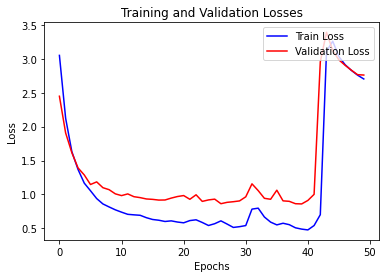

In [18]:
num_epochs = 50
best_model,max_accuracy = fit_model(model,num_epochs,train_dataloader,validation_dataloader)

We performed multiple experiments on the training and validation dataset. The model mentioned in the previous cell, is the last experiment we performed on LSTM.

Other experiments performed on GRU are:

In [ ]:
input_dim = 100 #10 previous stock values
hidden_dim = 128
num_layers = 1
output_dim = 50

random_seed = 2
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim,out_dim=output_dim, num_layers=num_layers)

In [19]:
torch.save(best_model,'ai_gru_dp_2_bs_model.pth')

# Testing the Trained Model

In [23]:
best_model = torch.load('ai_gru_dp_2_bs_model.pth')

In [24]:
from sklearn.metrics import classification_report

In [22]:
device = get_device()
predicted_results = []
y_true = []
for batch_idx,(feature_data,labels) in enumerate(validation_dataloader):
    feature_data = feature_data.to(device)
    labels = labels.to(device)
    output = best_model(feature_data)
    _,predicted = torch.max(output.data,1)
    predicted_results = predicted_results+list(predicted.cpu().detach().numpy())
    y_true +=  list(labels.cpu().detach().numpy())
    
print(len(predicted_results))

10736


In [25]:
print(classification_report(y_true, predicted_results))

              precision    recall  f1-score   support

           0       0.71      0.93      0.81       165
           1       0.71      0.39      0.50        75
           2       0.64      0.24      0.35        38
           3       0.71      0.62      0.66       317
           5       0.57      0.40      0.47        70
           7       0.90      0.84      0.87      1353
           8       0.74      0.62      0.67       214
           9       0.77      0.79      0.78       159
          10       0.77      0.49      0.60        73
          11       0.80      0.70      0.75       143
          12       0.73      0.65      0.69        88
          13       0.86      0.89      0.88       512
          14       0.82      0.81      0.81       261
          15       1.00      0.17      0.29        41
          16       0.62      0.58      0.60       135
          17       0.67      0.85      0.75       213
          18       0.84      0.85      0.85       325
          19       0.93    